## 1. 데이터셋 로딩 및 전처리

### 1-1. 데이터셋 불러오기

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [25]:
train = pd.read_csv('fog_train.csv', index_col=0).rename(columns=lambda x: x.split('.')[1])
test = pd.read_csv('fog_test.csv', index_col=0).rename(columns=lambda x: x.split('.')[1])

### 1-2. 데이터셋 분포 확인

In [4]:
# 클래스별 비율 확인
np.round(
    train['class'].value_counts(normalize=True).to_frame().reset_index().sort_values('index').set_index('index') * 100
, 3).astype(str) + '%'

,class
index,
-99,0.713%
1,0.249%
2,0.383%
3,0.386%
4,98.269%


In [93]:
np.round(
    train['class'].replace(-99, np.nan).replace(-99.9, np.nan)\
    .value_counts(normalize=True).to_frame().reset_index().sort_values('index').set_index('index') * 100
, 3).astype(str) + '%'

,class
index,
1.0,0.251%
2.0,0.386%
3.0,0.389%
4.0,98.975%


In [94]:
np.round(
    train['class'].replace(-99, np.nan).replace(-99.9, np.nan)\
    .value_counts().to_frame().reset_index().sort_values('index').set_index('index')
, 3)

,class
index,
1.0,7866
2.0,12088
3.0,12180
4.0,3101809


### 1-3. 전처리

In [26]:
# 지역 처리
train['stn_group'] = train['stn_id'].str[0]
train['stn_group_binary'] = train['stn_group'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5})

test['stn_group'] = test['stn_id'].str[0]
test['stn_group_binary'] = test['stn_group'].map({'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5})

In [27]:
# 안 쓰는 컬럼 drop
drop_columns = ['year', 'month', 'day', 'time', 'minute'] + ['stn_id', 'stn_group']

# train에서 class가 -99인 데이터(결측치) drop
train['class'] = train['class'].replace(-99, np.nan).replace(-99.9, np.nan) - 1
train = train.replace(-99, np.nan).replace(-99.9, np.nan)

train_drop = train.dropna().drop(drop_columns, axis=1).drop('vis1', axis=1).reset_index(drop=True)
test_drop = test.drop(drop_columns, axis=1).drop('class', axis=1).reset_index(drop=True)

train_drop.shape, test_drop.shape

((2994850, 9), (262800, 8))

### 1-4. 과소표집

```imbalanced-learn``` 모듈을 이용하면 좋다.

1. **랜덤 과소표집 (Random Under-Sampling)**:
   - 가장 기본적인 방법으로, 다수 클래스의 샘플을 무작위로 선택하여 소수 클래스의 샘플 수와 같거나 비슷하게 맞춥니다.
   - 장점: 구현이 간단하고 빠름.
   - 단점: 중요한 정보를 잃을 가능성이 있음.


2. **클러스터 중심 과소표집 (Cluster Centroids)**:
   - K-means 클러스터링을 사용하여 다수 클래스 샘플을 몇 개의 클러스터로 묶은 다음, 각 클러스터의 중심을 대표 샘플로 사용합니다.
   - 장점: 데이터의 구조를 고려하여 샘플 수를 줄임.
   - 단점: 클러스터링의 결과에 따라 성능이 달라질 수 있음.


3. **토메크 링크 (Tomek Links)**:
   - 서로 다른 클래스에 속하는 샘플 쌍(토메크 링크)을 찾아 제거하여 클래스 간의 경계를 더 명확히 함.
   - 장점: 데이터의 경계를 명확히 하여 모델의 성능을 향상시킬 수 있음.
   - 단점: 처리 속도가 상대적으로 느릴 수 있음.


4. **편향된 무작위 과소표집 (NearMiss)**:
   - 다수 클래스 샘플 중 소수 클래스 샘플과 가장 가까운 샘플을 선택하거나, 소수 클래스 샘플과의 평균 거리가 가까운 샘플을 선택하는 방식.
   - 여러 가지 변형이 있으며, 데이터의 특성에 맞게 선택할 수 있음.
   - 장점: 중요한 샘플을 유지할 가능성이 높음.
   - 단점: 설정과 튜닝이 필요함.


5. **Condensed Nearest Neighbor (CNN)**:
   - KNN(K-Nearest Neighbor) 알고리즘을 사용하여 다수 클래스 샘플 중에서 필수적인 샘플만 남기고 나머지를 제거함.
   - 장점: 모델의 성능을 향상시킬 수 있는 중요한 샘플만 유지.
   - 단점: 연산 비용이 높을 수 있음.


6. **Edited Nearest Neighbor (ENN)**:
   - KNN 알고리즘을 사용하여 잘못 분류된 샘플을 제거함으로써 데이터의 품질을 높임.
   - 장점: 데이터의 노이즈를 줄여 모델의 성능을 향상시킬 수 있음.
   - 단점: 과소표집 과정에서 데이터 손실이 발생할 수 있음.

In [7]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

X = train_drop.drop('class', axis=1)
y = train_drop['class']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, train_size=0.75, stratify=y)

start_time = datetime.now()
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)
# X_res_rus, y_res_rus = rus.fit_resample(X_train, y_train)
time_delta = datetime.now() - start_time
print(f'''[Random Under-Sampling] Resampled dataset shape: {Counter(y_res_rus)}, 학습 시간: {time_delta.seconds}.{time_delta.microseconds // 10000}s''')

[Random Under-Sampling] Resampled dataset shape: Counter({0.0: 5899, 1.0: 5899, 2.0: 5899, 3.0: 5899}), 학습 시간: 0.38s


### 1-5. 데이터셋 분리

In [10]:
X_test = test_drop
X = train_drop.drop('class', axis=1)
y = train_drop['class']

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, train_size=0.75, stratify=y)
# X_train, X_val, y_train, y_val = train_test_split(X_res_rus, y_res_rus, random_state=42, train_size=0.75, stratify=y_res_rus)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((2350457, 8), (783486, 8), (2350457,), (783486,))

---

## 2. EDA

In [28]:
train_drop

,ws10_deg,ws10_ms,ta,re,hm,sun10,ts,class,stn_group_binary
0,0.0,0.0,-6.4,0.0,38.9,0.0,-2.8,3.0,1
1,0.0,0.0,-6.3,0.0,37.9,0.0,-2.7,3.0,1
2,0.0,0.0,-6.3,0.0,40.0,0.0,-2.6,3.0,1
3,27.8,0.4,-6.2,0.0,39.5,0.0,-2.6,3.0,1
4,59.7,0.5,-6.1,0.0,39.8,0.0,-2.5,3.0,1
...,...,...,...,...,...,...,...,...,...
2994845,305.3,7.7,2.5,0.0,50.2,0.0,-0.9,3.0,5
2994846,293.8,5.7,2.3,0.0,50.1,0.0,-1.3,3.0,5
2994847,274.2,4.9,2.2,0.0,51.0,0.0,-1.4,3.0,5
2994848,270.3,4.6,2.1,0.0,51.7,0.0,-1.6,3.0,5


In [38]:
train_drop['is_fog'] = train_drop['class'].apply(lambda x: 0 if x >= 3 else 1)
train_drop['is_fog'].value_counts(normalize=True).to_frame()

,is_fog
0,0.989408
1,0.010592


### 2-1. 바람

In [29]:
train_drop['ws10_deg'].min()

0.0

In [30]:
train_drop['ws10_dir'] = train_drop['ws10_deg'].apply(lambda x: round(x / 90))
train_drop['ws10_dir'].value_counts(sort=False)

0     408830
1     686592
2     556166
3    1025752
4     317510
Name: ws10_dir, dtype: int64

동서남북 방향이니까 0은 4와 같다.

In [48]:
train_drop['ws10_dir'] = train_drop['ws10_dir'].replace(4, 0)
train_drop['ws10_dir'].value_counts(sort=False).to_frame()

,ws10_dir
0,726340
1,686592
2,556166
3,1025752


0(북풍), 1(동풍), 2(남풍), 3(서풍)이고 **서풍**의 빈도가 가장 높다.

In [72]:
(np.round(
    train_drop.groupby('is_fog')['ws10_dir'].value_counts(normalize=True, sort=False).unstack() * 100
, 2).astype(str) + '%').rename(columns={0: '북', 1: '동', 2: '남', 3: '서'})[['동', '서', '남', '북']]

ws10_dir,동,서,남,북
is_fog,,,,
0,22.91%,34.38%,18.54%,24.17%
1,24.33%,22.44%,21.57%,31.66%


근데 안개 여부에 따라 발라서 보면 조금 달라진다. 평상시엔 서풍이 가장 많지만, 안개가 낀 날에는 **북풍**이 가장 많다.

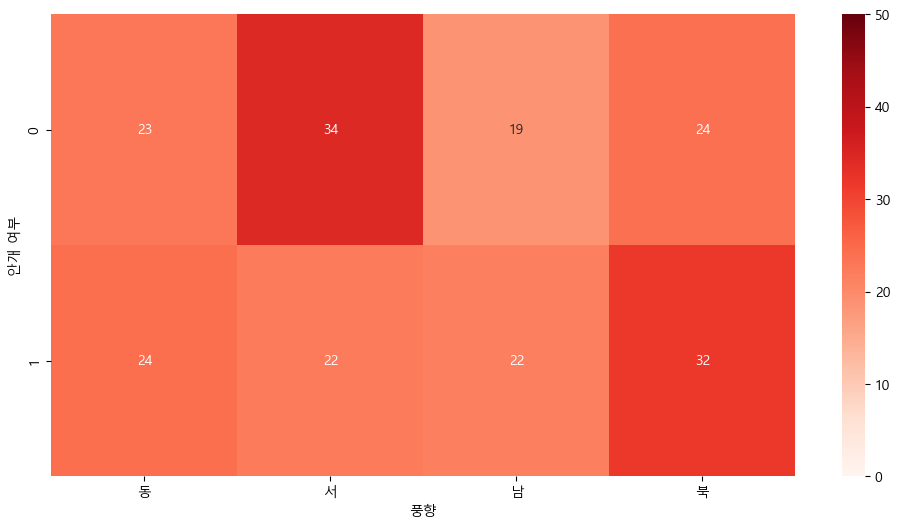

In [74]:
plt.figure(figsize=(12, 6))

sns.heatmap(
    (train_drop.groupby('is_fog')['ws10_dir'].value_counts(normalize=True, sort=False).unstack() * 100)\
    .rename(columns={0: '북', 1: '동', 2: '남', 3: '서'})[['동', '서', '남', '북']],
    vmax=50,
    vmin=0,
    cmap='Reds',
    annot=True
)

plt.xlabel('풍향')
plt.ylabel('안개 여부')
plt.xticks()

plt.show()

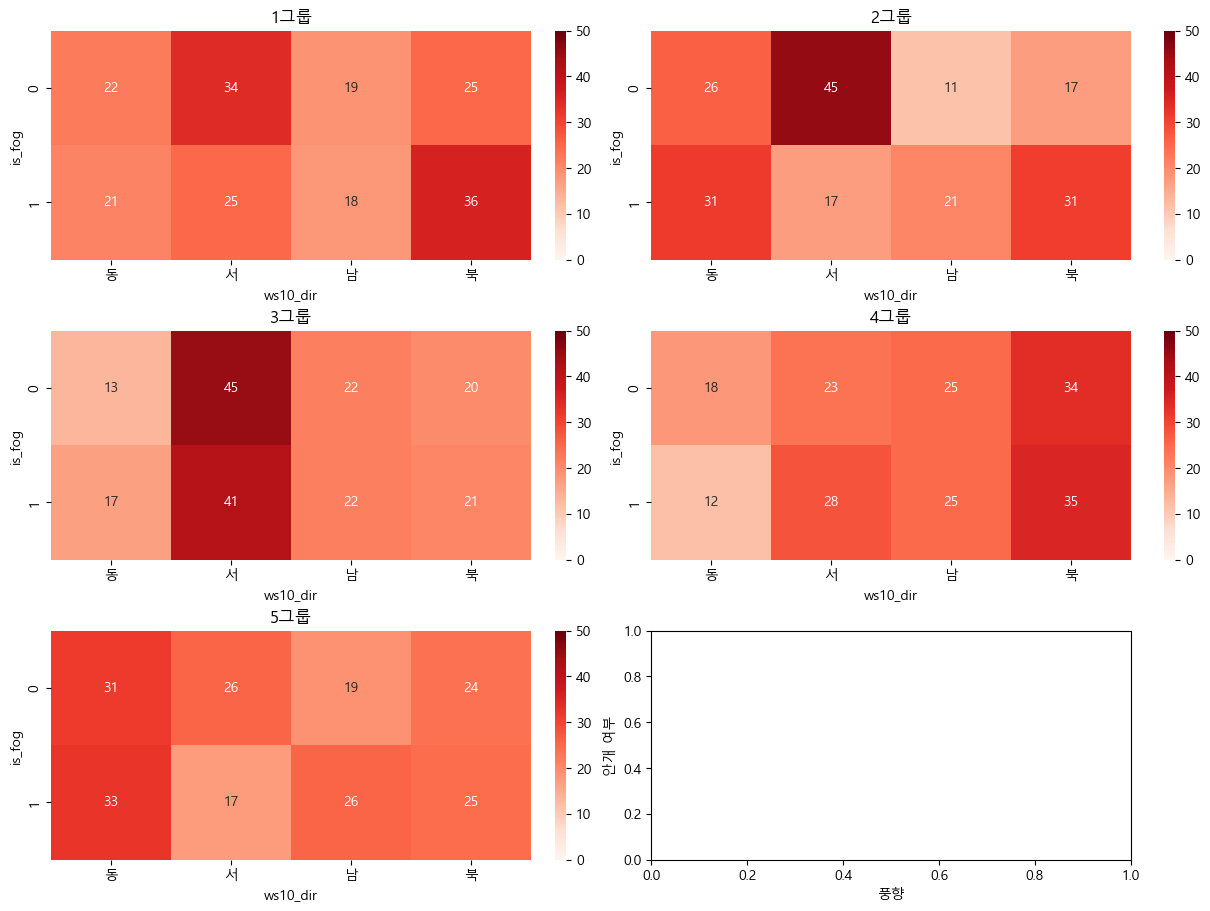

In [75]:
fig, axes = plt.subplots(figsize=(12, 9), ncols=2, nrows=3, constrained_layout=True)

for i, (stn_group_binary, df) in enumerate(train_drop.groupby('stn_group_binary')):
    sns.heatmap(
        (df.groupby('is_fog')['ws10_dir'].value_counts(normalize=True, sort=False).unstack() * 100)\
        .rename(columns={0: '북', 1: '동', 2: '남', 3: '서'})[['동', '서', '남', '북']],
        vmax=50,
        vmin=0,
        cmap='Reds',
        annot=True,
        ax=axes[i // 2][i % 2]
    )
    
    axes[i // 2][i % 2].set_title(f'{stn_group_binary}그룹')

plt.xlabel('풍향')
plt.ylabel('안개 여부')

plt.show()

**지역에 따라** 풍향이 다른 영향을 준다. 예를 들어, 1그룹에서는 북풍이 안개 발생을 주도하는 반면, 2그룹은 북동풍의 영향을 크게 받는다. 3그룹, 4그룹, 5그룹은 평상시의 풍향과 안개 꼈을 때의 풍향이 유사한 수준으로 보인다.

In [83]:
pd.options.display.float_format = '{:,.3f}'.format

In [84]:
print("=" * 30)
for is_fog, df in train_drop.groupby('is_fog'):
    print("[ 안개가 낀 경우 ]") if is_fog else print("[ 평상시 ]")
    print(df['ws10_ms'].describe())
    print("=" * 30)

[ 평상시 ]
count   2,963,129.000
mean            2.196
std             1.752
min             0.000
25%             0.900
50%             1.800
75%             3.100
max            21.100
Name: ws10_ms, dtype: float64
[ 안개가 낀 경우 ]
count   31,721.000
mean         1.379
std          1.546
min          0.000
25%          0.300
50%          0.900
75%          2.000
max         21.600
Name: ws10_ms, dtype: float64


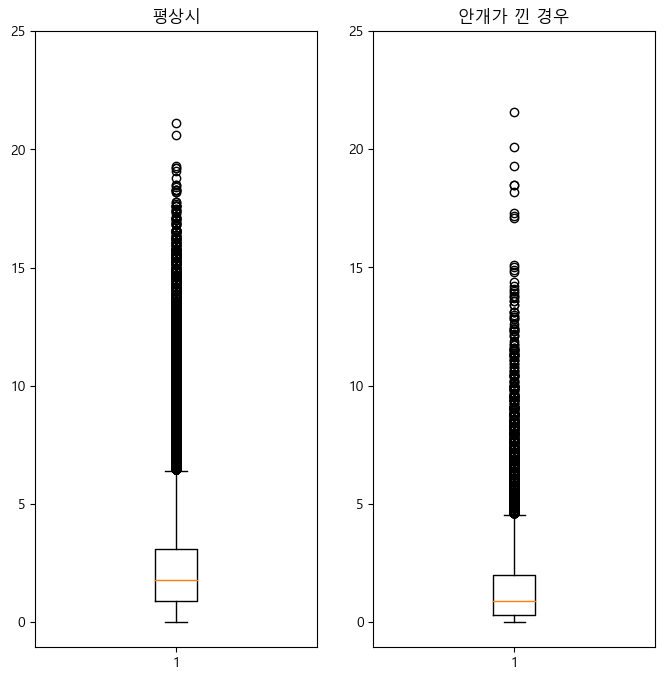

In [90]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 8))

for i in range(2):
    axes[i].boxplot(
        train_drop[train_drop['is_fog'] == i]['ws10_ms']
    )
    title = "안개가 낀 경우" if i else "평상시"
    axes[i].set_title(title)
    axes[i].set_yticks([i for i in range(0, 26, 5)])

plt.show()

큰 차이는 아니지만 안개가 꼈을 때 순간풍속이 조금 낮은 것 같다.

### 2-2. 기온

C:\Users\louis\anaconda3\envs\ml\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


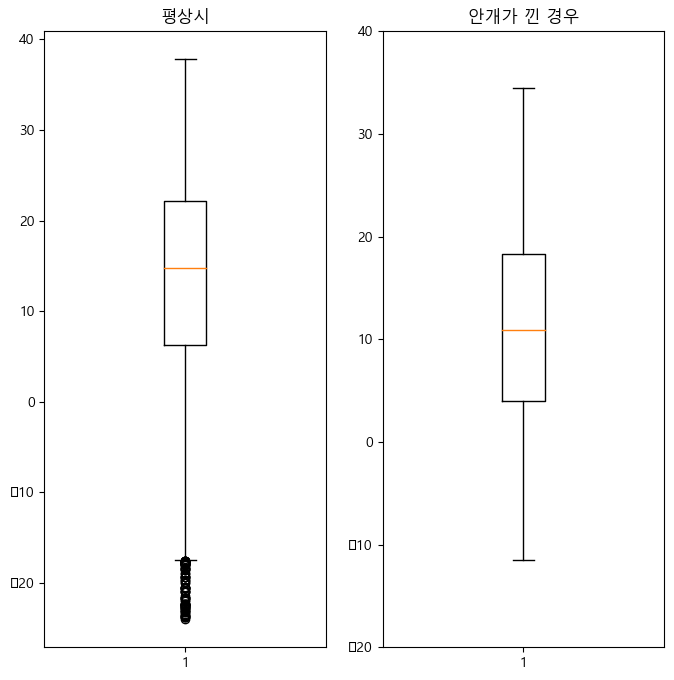

In [95]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 8))

for i in range(2):
    axes[i].boxplot(
        train_drop[train_drop['is_fog'] == i]['ta']
    )
    title = "안개가 낀 경우" if i else "평상시"
    axes[i].set_title(title)
    axes[i].set_yticks([i for i in range(-20, 41, 10)])

plt.show()

C:\Users\louis\anaconda3\envs\ml\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


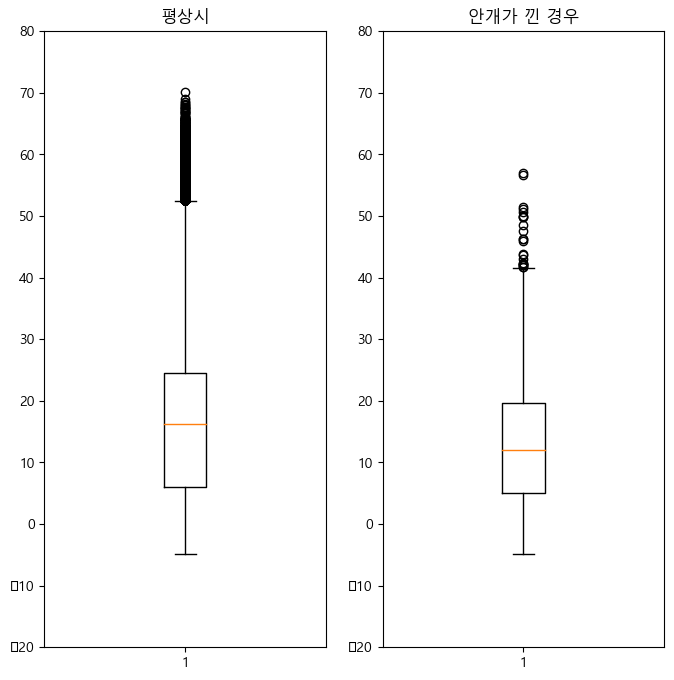

In [98]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 8))

for i in range(2):
    axes[i].boxplot(
        train_drop[train_drop['is_fog'] == i]['ts']
    )
    title = "안개가 낀 경우" if i else "평상시"
    axes[i].set_title(title)
    axes[i].set_yticks([i for i in range(-20, 81, 10)])

plt.show()

In [99]:
train_drop['ts-ta'] = train_drop['ts'] - train_drop['ta']

C:\Users\louis\anaconda3\envs\ml\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


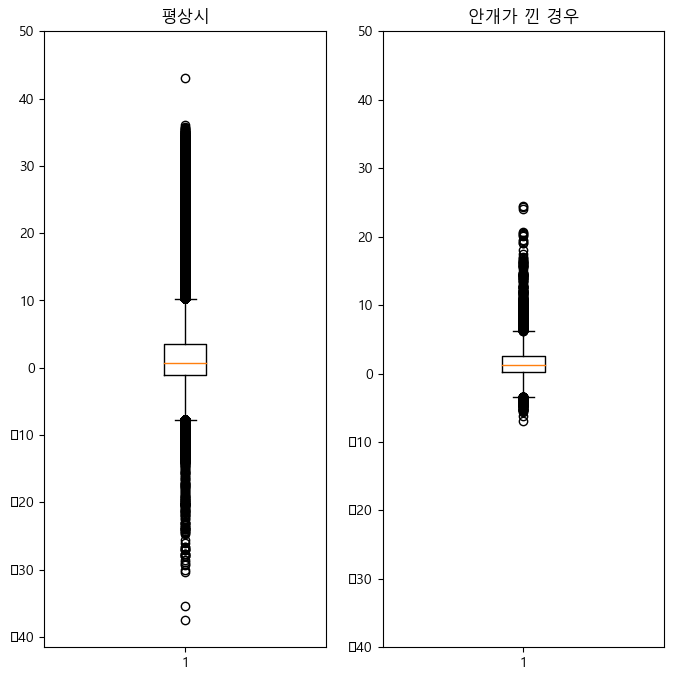

In [101]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 8))

for i in range(2):
    axes[i].boxplot(
        train_drop[train_drop['is_fog'] == i]['ts-ta']
    )
    title = "안개가 낀 경우" if i else "평상시"
    axes[i].set_title(title)
    axes[i].set_yticks([i for i in range(-40, 51, 10)])

plt.show()

### 2-3. 강수 여부, 상대습도

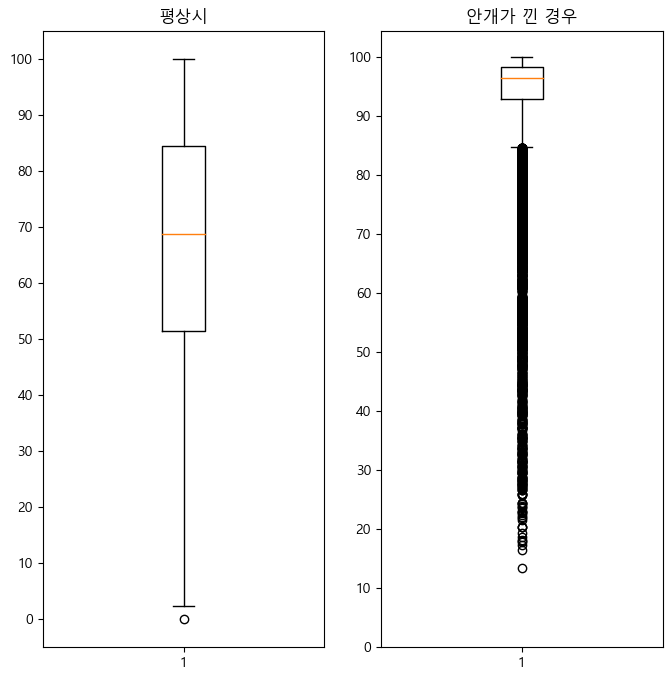

In [103]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 8))

for i in range(2):
    axes[i].boxplot(
        train_drop[train_drop['is_fog'] == i]['hm']
    )
    title = "안개가 낀 경우" if i else "평상시"
    axes[i].set_title(title)
    axes[i].set_yticks([i for i in range(0, 101, 10)])

plt.show()

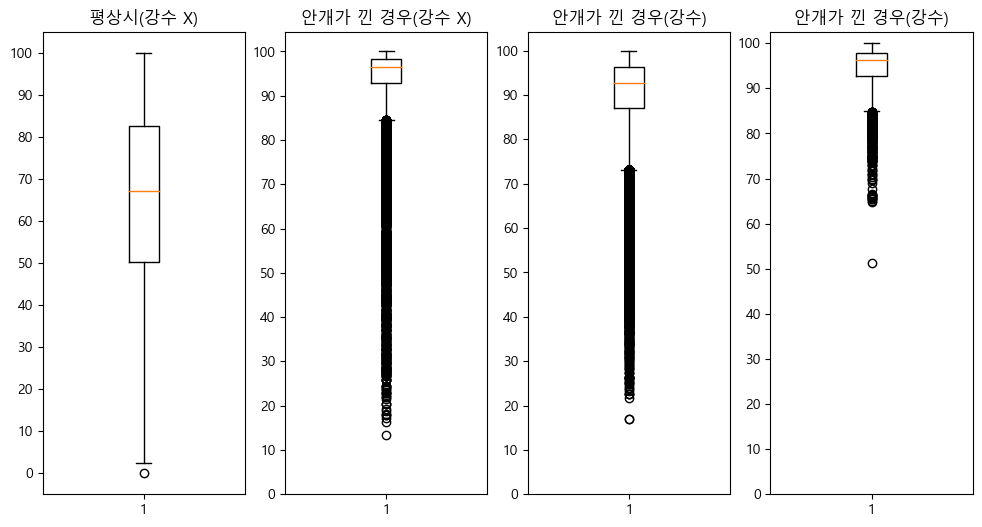

In [108]:
fig, axes = plt.subplots(ncols=4, figsize=(12, 6))

for i in range(2):
    axes[i].boxplot(
        train_drop[(train_drop['is_fog'] == i) & (train_drop['re'] == 0)]['hm']
    )
    title = "안개가 낀 경우(강수 X)" if i else "평상시(강수 X)"
    axes[i].set_title(title)
    axes[i].set_yticks([i for i in range(0, 101, 10)])

for i in range(2, 4):
    axes[i].boxplot(
        train_drop[(train_drop['is_fog'] == i - 2) & (train_drop['re'] == 1)]['hm']
    )
    title = "안개가 낀 경우(강수)" if i else "평상시(강수)"
    axes[i].set_title(title)
    axes[i].set_yticks([i for i in range(0, 101, 10)])
    
plt.show()

---